Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import CNN

# from config_plots import global_settings
# global_settings()
import warnings
warnings.filterwarnings("ignore")

Hyper parameters

In [2]:
# defining global variables
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_multilayer"
showListOfSpecies = False

from configParser import ConfigParser, getModelName
config_parser = ConfigParser(experimentName)

import os
experimentName = os.path.join(experimentName, "multi-trial")
import TrialStatistics
ts = TrialStatistics.TrialStatistics(experimentName)
ts_genus = TrialStatistics.TrialStatistics(experimentName, "genus")

import dataLoader

Cuda support

In [3]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


Iterate

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from confusion_matrix_plotter import plot_confusion_matrix2, generate_classification_report
import numpy as np
import os
import progressbar

paramsIterator = config_parser.getHyperpIter()  
number_of_experiments = sum(1 for e in paramsIterator)
paramsIterator = config_parser.getHyperpIter()  
experiment_index = 0

datasetManager = dataLoader.datasetManager(experimentName, showListOfSpecies)
with progressbar.ProgressBar(max_value=number_of_experiments) as bar:
    for experiment_params in paramsIterator:
        bar.update(experiment_index)
        experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1

        print("experiment ", experiment_index+1, "/", number_of_experiments, ": ", experiment_params)

        # load images
        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
        speciesList = dataset.getSpeciesList()
        numberOfSpecies = len(speciesList)
        numberOfGenus = len(dataset.getGenusList())

        confusionMatricesPerTrial = []

        for i in range(experiment_params["numOfTrials"]):
            trialName = os.path.join(experimentName, getModelName(experiment_params, i))

            # Train/Load model
            architecture = {
                "species": numberOfSpecies,
                "genus" : numberOfGenus
            }
            model = CNN.create_model(architecture, experiment_params)
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            if os.path.exists(CNN.getModelFile(trialName)):
                _, _, epochs, time_elapsed = CNN.loadModel(model, trialName)
                print("Model {0} loaded!".format(trialName))
            else:
                _, _, epochs, time_elapsed = CNN.trainModel(train_loader, validation_loader, experiment_params, model, trialName)
            
            # Update trial outcomes for statistics
            predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params)
            ts.addTrialPredictions(experiment_params, predlist, lbllist, numberOfSpecies)
            macro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')
            macro_f1_genus = np.nan
            if experiment_params["useHeirarchy"]:
                predlist, lbllist = CNN.getLoaderPredictions(test_loader, model, experiment_params, 'genus')
                ts_genus.addTrialPredictions(experiment_params, predlist, lbllist, numberOfGenus)
                macro_f1_genus = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

            ts.addTrial(experiment_params,
                    {'loss': CNN.getCrossEntropyFromLoader(test_loader, model, experiment_params),
                     'accuracy': CNN.getAccuracyFromLoader(test_loader, model, experiment_params),
                     'macro_f1_species': macro_f1,
                     'macro_f1_genus': macro_f1_genus,
                     'time': time_elapsed,
                     'epochs': epochs
                    }, i)
        
        experiment_index = experiment_index + 1

N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

experiment  1 / 3 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': True, 'resnet': '18', 'normalize': False}
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/dataset.pkl read
Loading saved dataloaders...
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/trainingLoader.pkl read
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_multilayer

 33% (1 of 3) |########                  | Elapsed Time: 0:02:12 ETA:   0:04:24

experiment  2 / 3 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 2, 'useAdam': True, 'resnet': '18', 'normalize': False}
Model test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.000100_hTrue_reluTrue_dsTrue_dso50_tfiTrue_tfio50_admTrue_res18_fc2_smaxFalse_id0 loaded!
Model test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.000100_hTrue_reluTrue_dsTrue_dso50_tfiTrue_tfio50_admTrue_res18_fc2_smaxFalse_id1 loaded!
Model test

 66% (2 of 3) |#################         | Elapsed Time: 0:02:44 ETA:   0:00:32

experiment  3 / 3 :  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 3, 'useAdam': True, 'resnet': '18', 'normalize': False}
Model test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.000100_hTrue_reluTrue_dsTrue_dso50_tfiTrue_tfio50_admTrue_res18_fc3_smaxFalse_id0 loaded!
Model test_22987_suffix50_11_CNN2_differentConfig_multilayer/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse_bs550_e1000_p100_lr0.000100_hTrue_reluTrue_dsTrue_dso50_tfiTrue_tfio50_admTrue_res18_fc3_smaxFalse_id1 loaded!
Model test

100% (3 of 3) |##########################| Elapsed Time: 0:03:17 Time:  0:03:17


Analyze

In [5]:
ts.showStatistics()
ts.saveStatistics()

Aggregated statistics


In [6]:
ts.showStatistics(False)
ts.saveStatistics(False)

Raw statistics


,image_path,suffix,training_count,softmax,validation_count,imageDimension,n_channels,augmentation,batchSize,n_epochs,learning_rate,numOfTrials,patience,useHeirarchy,useRelu,downsample,downsampleOutput,takeFromIntermediate,takeFromIntermediateOutput,fc_layers,useAdam,resnet,normalize,loss,accuracy,macro_f1_species,macro_f1_genus,time,epochs,hash,trial
0,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,1,True,18,False,1.981390,0.663636,0.600804,0.476190,12627.869981,1000.0,2718724715385681570,0
1,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,1,True,18,False,1.329377,0.736364,0.704258,0.533613,12548.248873,1000.0,2718724715385681570,1
2,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,1,True,18,False,1.417652,0.745455,0.712639,0.598412,12063.743141,1000.0,2718724715385681570,2
3,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,2,True,18,False,0.585415,0.790909,0.792115,0.737912,11841.110517,1000.0,-4616172347954736629,0
4,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,2,True,18,False,0.669548,0.809091,0.802252,0.459649,11283.032959,949.0,-4616172347954736629,1
5,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,2,True,18,False,0.781189,0.790909,0.783043,0.218945,10287.839486,867.0,-4616172347954736629,2
6,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,3,True,18,False,2.434367,0.754545,0.717917,0.061538,8255.078447,691.0,-1739835566695557097,0
7,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,3,True,18,False,0.709116,0.809091,0.803965,0.487763,11115.975499,930.0,-1739835566695557097,1
8,/data/BGNN_data/INHS_cropped,50_11,0.64,False,0.16,224,3,False,550,1000,0.0001,3,100,True,True,True,50,True,50,3,True,18,False,1.856411,0.763636,0.736601,0.533333,8702.683818,730.0,-1739835566695557097,2


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': True, 'resnet': '18', 'normalize': False}


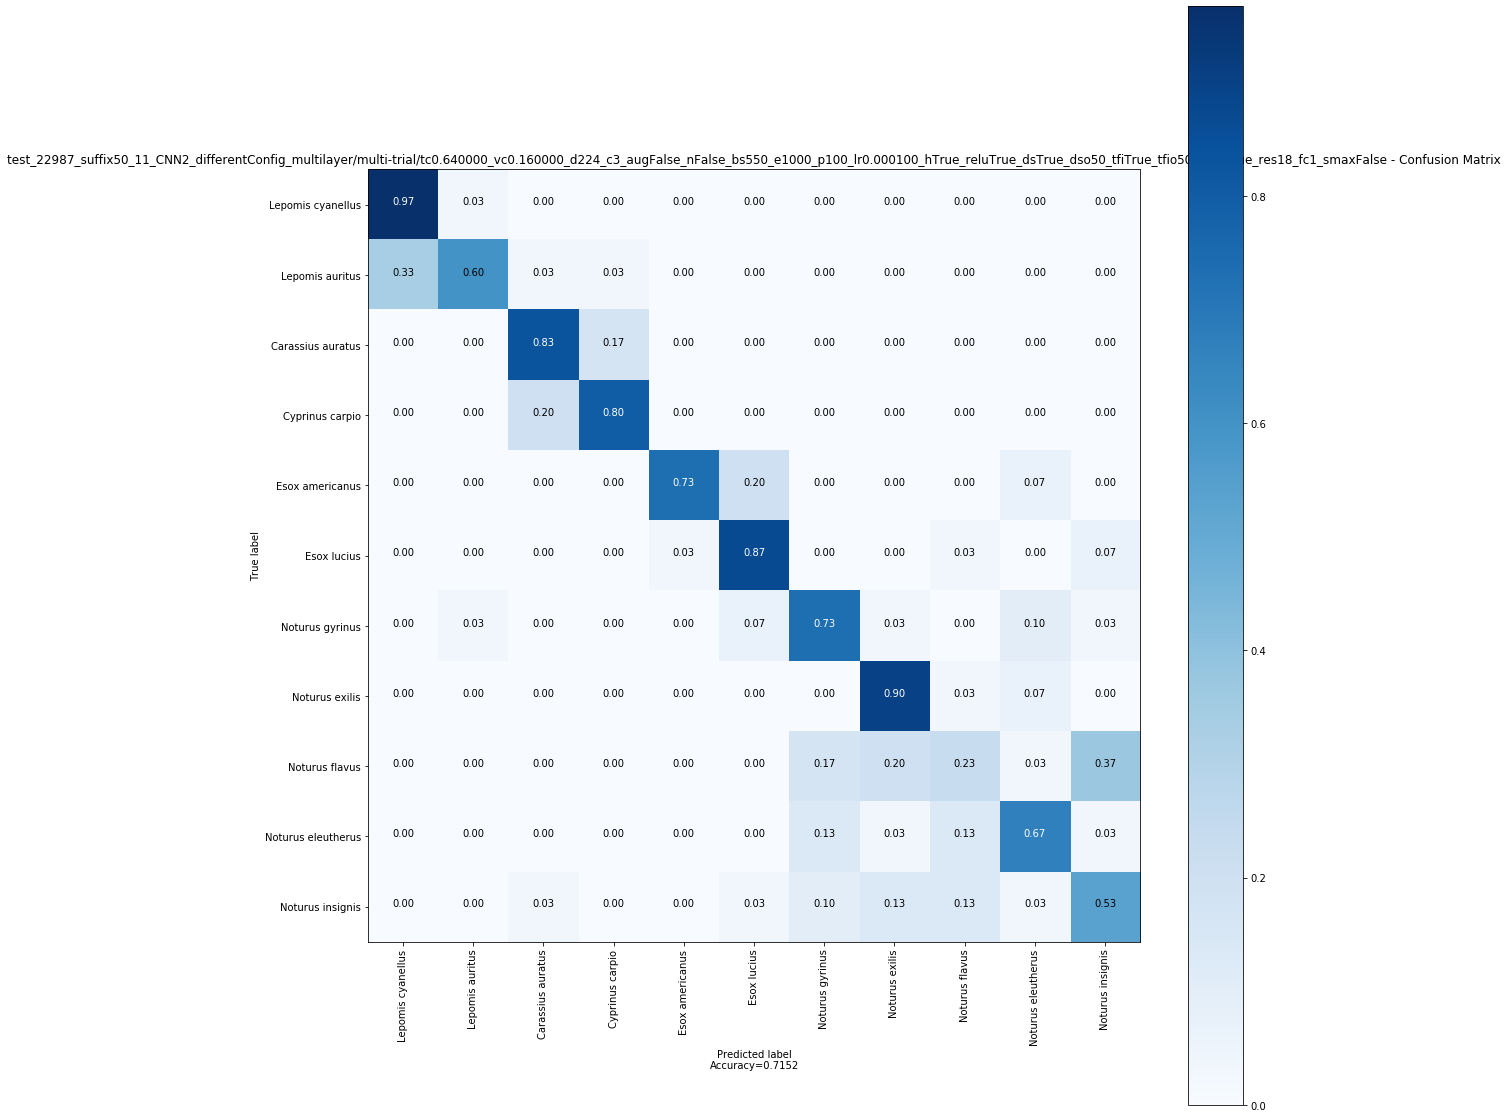

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.840580,0.840580,1.000000
1,1 Lepomis auritus,0 Lepomis,0.720000,0.765957,0.923077
2,2 Carassius auratus,1 Carassius,0.793651,1.000000,0.793651
3,3 Cyprinus carpio,2 Cyprinus,0.800000,1.000000,0.800000
4,4 Esox americanus,3 Esox,0.830189,0.862745,0.956522
5,5 Esox lucius,3 Esox,0.800000,0.881356,0.896552
6,6 Noturus gyrinus,4 Noturus,0.687500,0.721311,0.936170
7,7 Noturus exilis,4 Noturus,0.782609,0.782609,1.000000
8,8 Noturus flavus,4 Noturus,0.297872,0.304348,0.933333
9,9 Noturus eleutherus,4 Noturus,0.677966,0.701754,0.952381


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 2, 'useAdam': True, 'resnet': '18', 'normalize': False}


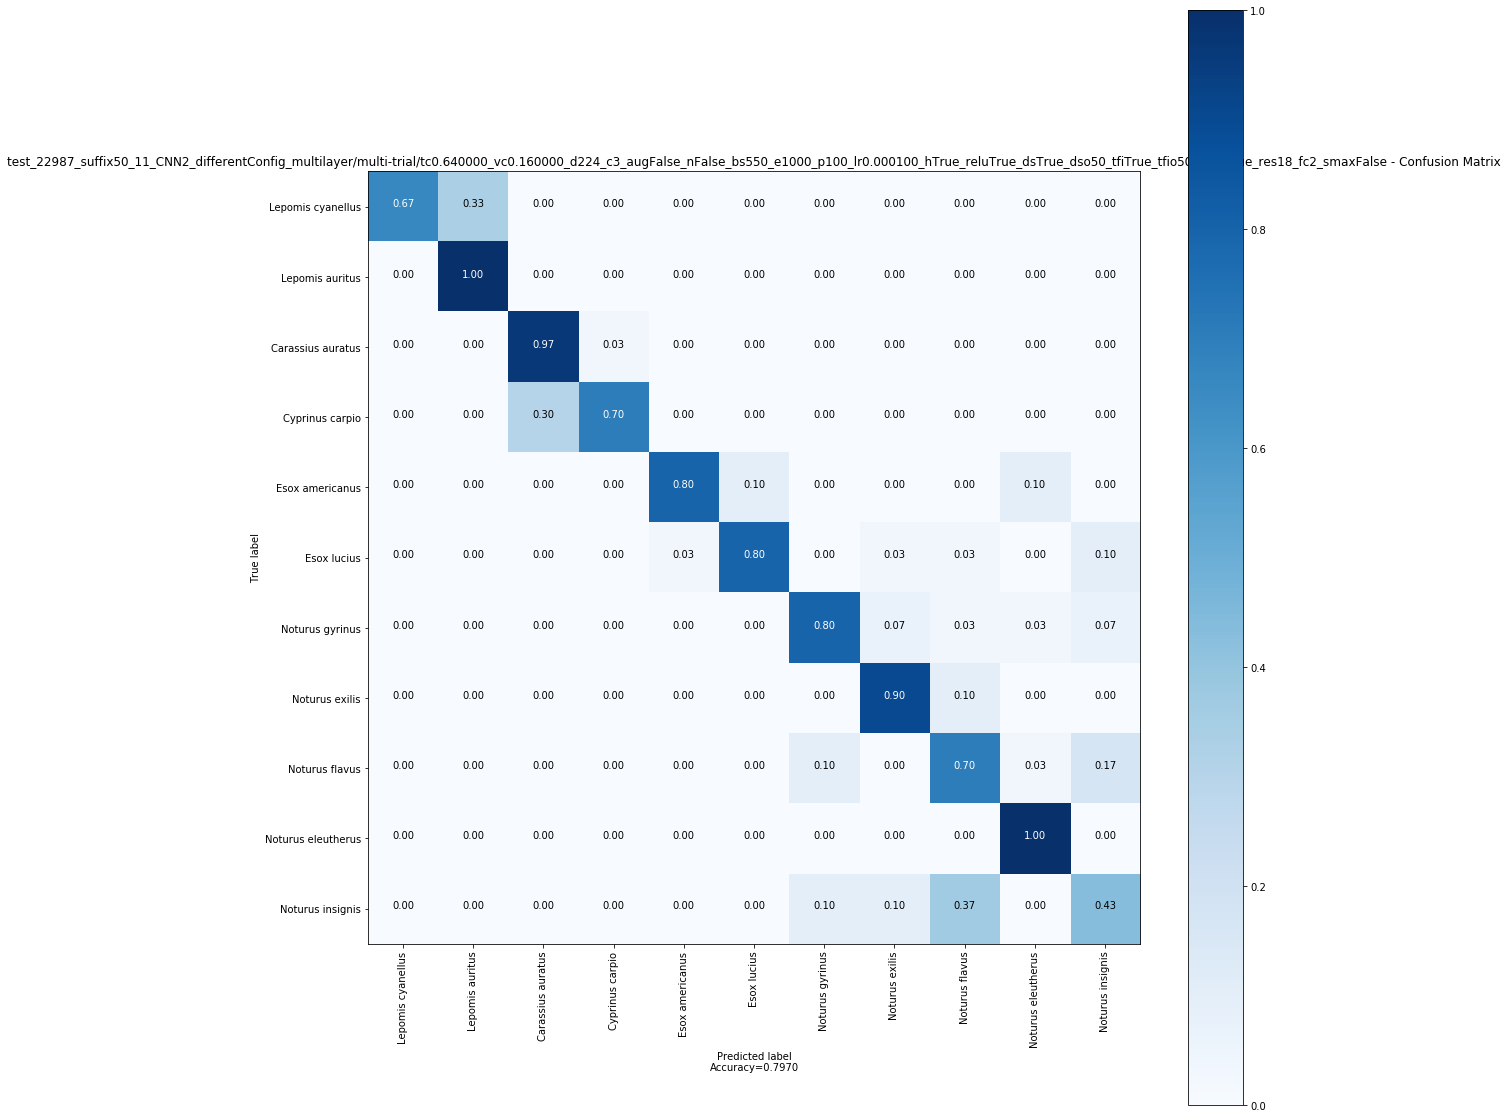

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.800000,0.800000,1.000000
1,1 Lepomis auritus,0 Lepomis,0.857143,0.857143,1.000000
2,2 Carassius auratus,1 Carassius,0.852941,1.000000,0.852941
3,3 Cyprinus carpio,2 Cyprinus,0.807692,1.000000,0.807692
4,4 Esox americanus,3 Esox,0.872727,0.923077,0.941176
5,5 Esox lucius,3 Esox,0.842105,0.923077,0.905660
6,6 Noturus gyrinus,4 Noturus,0.800000,0.800000,1.000000
7,7 Noturus exilis,4 Noturus,0.857143,0.870968,0.981818
8,8 Noturus flavus,4 Noturus,0.626866,0.636364,0.976744
9,9 Noturus eleutherus,4 Noturus,0.923077,0.967742,0.952381


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 3, 'useAdam': True, 'resnet': '18', 'normalize': False}


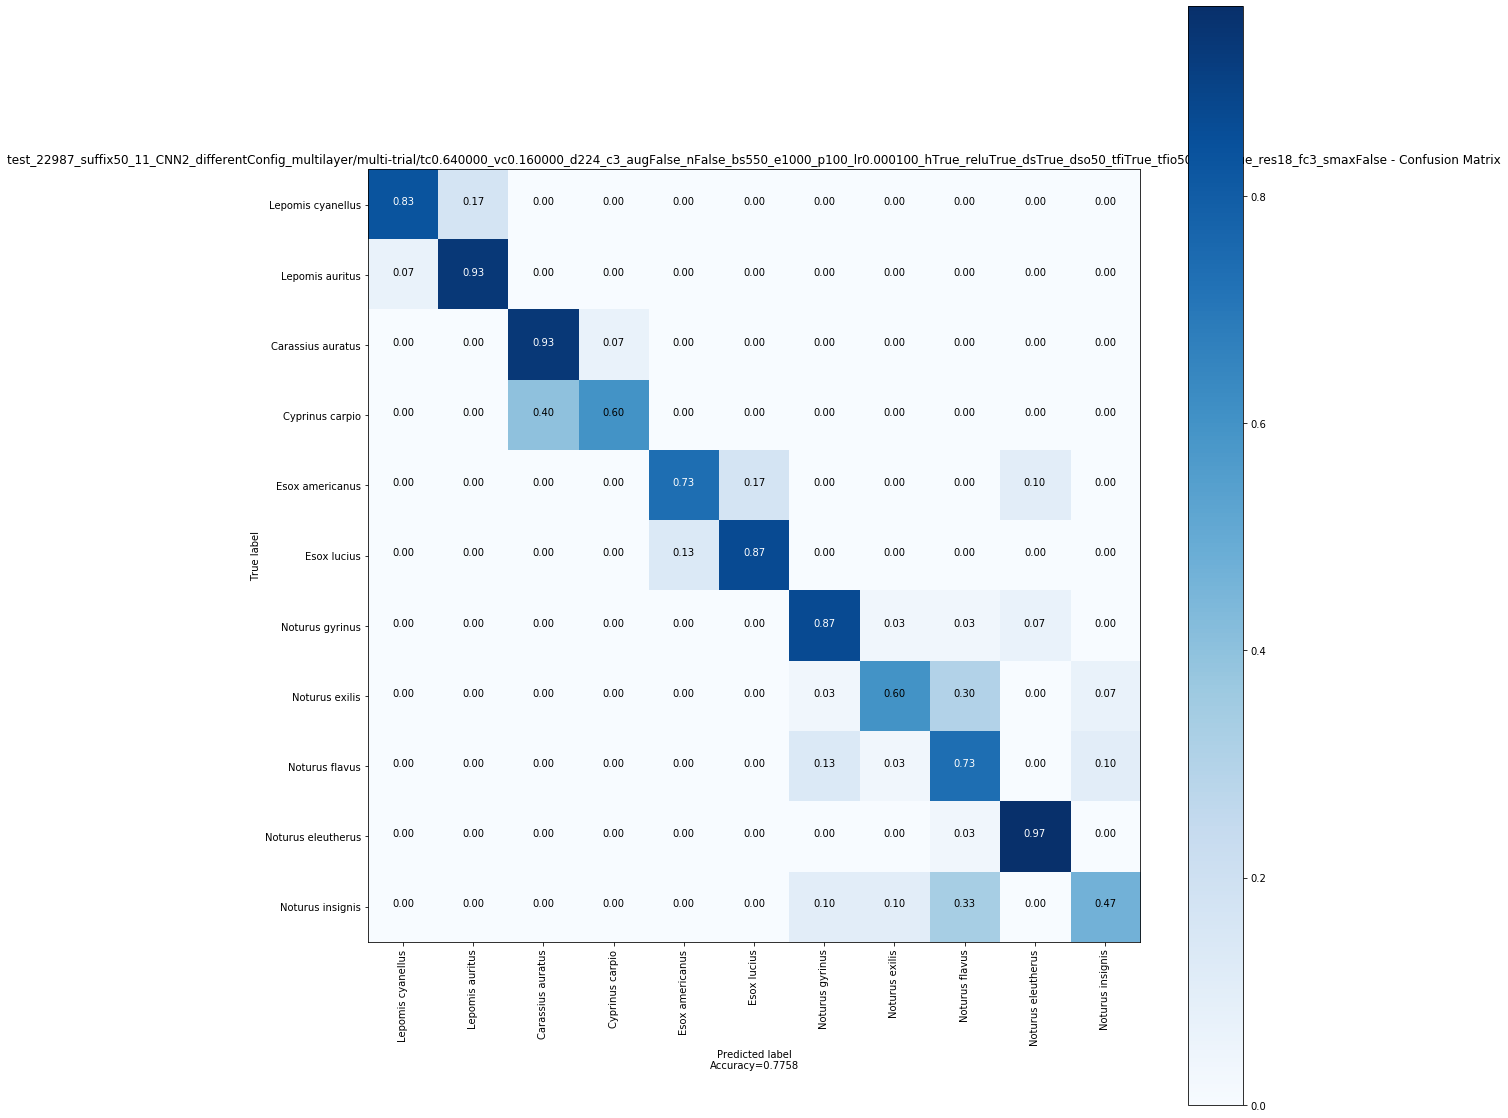

,species,genus,F1,F1_within_genus,F1_out_of_genus
0,0 Lepomis cyanellus,0 Lepomis,0.877193,0.877193,1.00000
1,1 Lepomis auritus,0 Lepomis,0.888889,0.888889,1.00000
2,2 Carassius auratus,1 Carassius,0.800000,1.000000,0.80000
3,3 Cyprinus carpio,2 Cyprinus,0.720000,1.000000,0.72000
4,4 Esox americanus,3 Esox,0.785714,0.830189,0.93617
5,5 Esox lucius,3 Esox,0.852459,0.852459,1.00000
6,6 Noturus gyrinus,4 Noturus,0.812500,0.812500,1.00000
7,7 Noturus exilis,4 Noturus,0.679245,0.679245,1.00000
8,8 Noturus flavus,4 Noturus,0.602740,0.602740,1.00000
9,9 Noturus eleutherus,4 Noturus,0.906250,0.950820,0.95082


In [7]:
paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    
    print("experiment: ", experiment_params)
    
    datasetManager.updateParams(experiment_params)
    dataset = datasetManager.getDataset()
    speciesList = dataset.getSpeciesList()
    ts.printTrialConfusionMatrix(experiment_params, speciesList, True)
    ts.printF1table(experiment_params, dataset)

experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': True, 'resnet': '18', 'normalize': False}


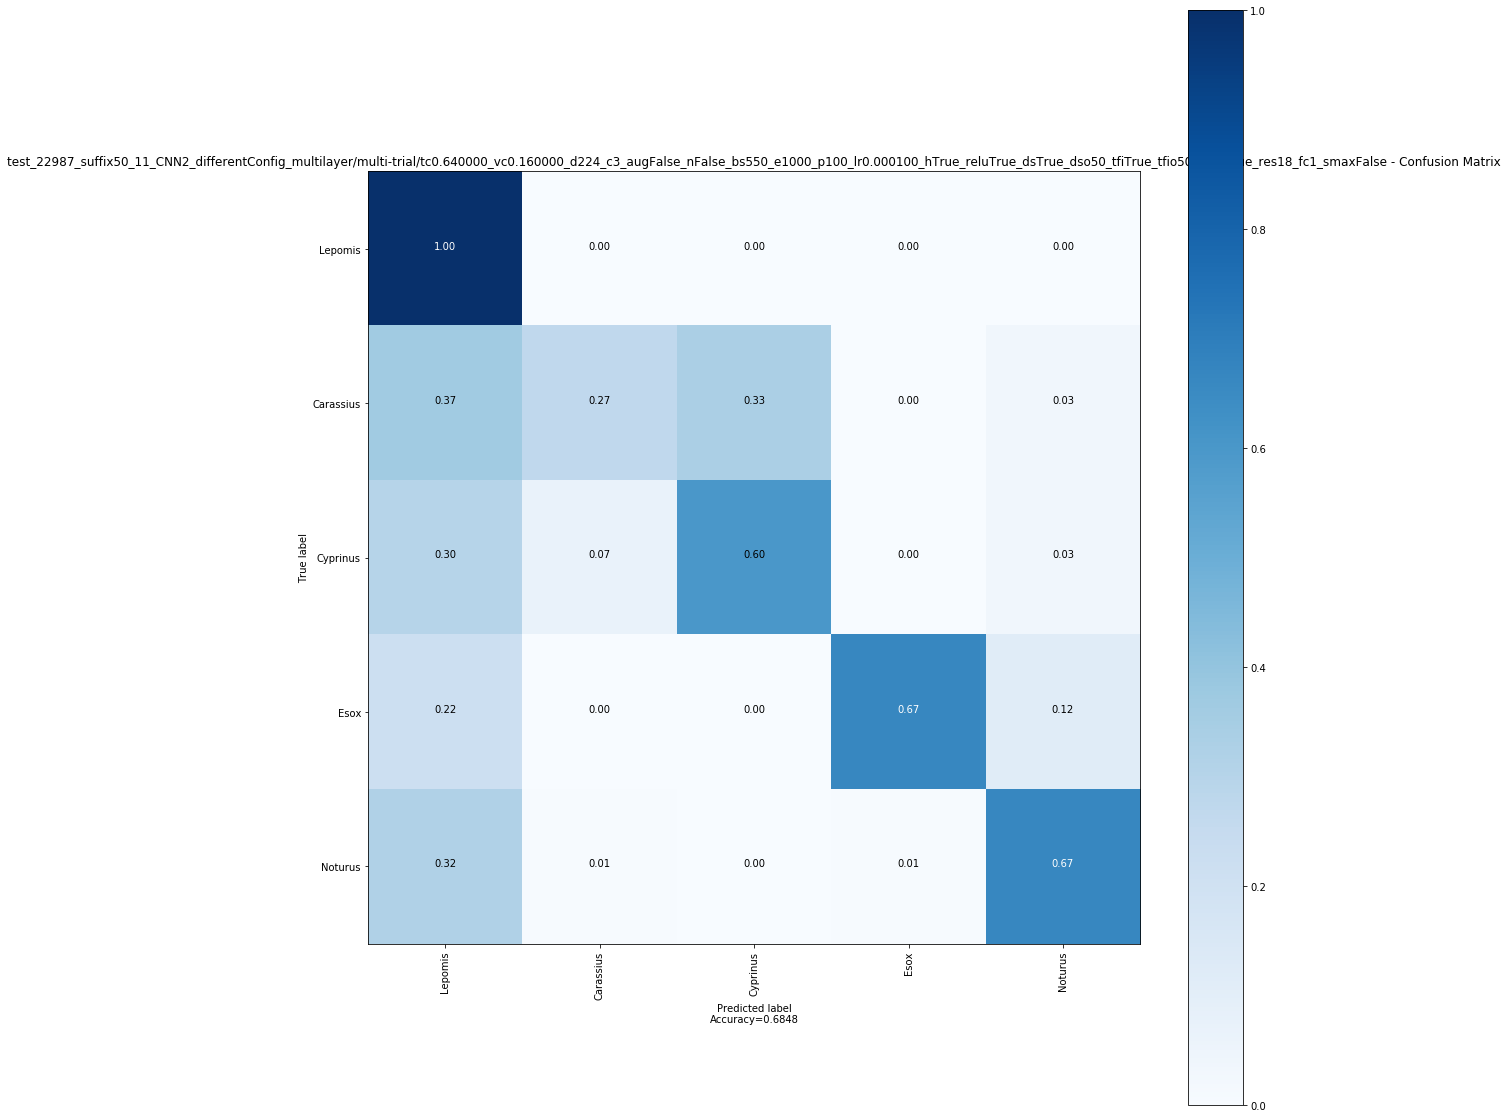

,genus,F1
0,0 Lepomis,0.597015
1,1 Carassius,0.390244
2,2 Cyprinus,0.620690
3,3 Esox,0.792079
4,4 Noturus,0.772201


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 2, 'useAdam': True, 'resnet': '18', 'normalize': False}


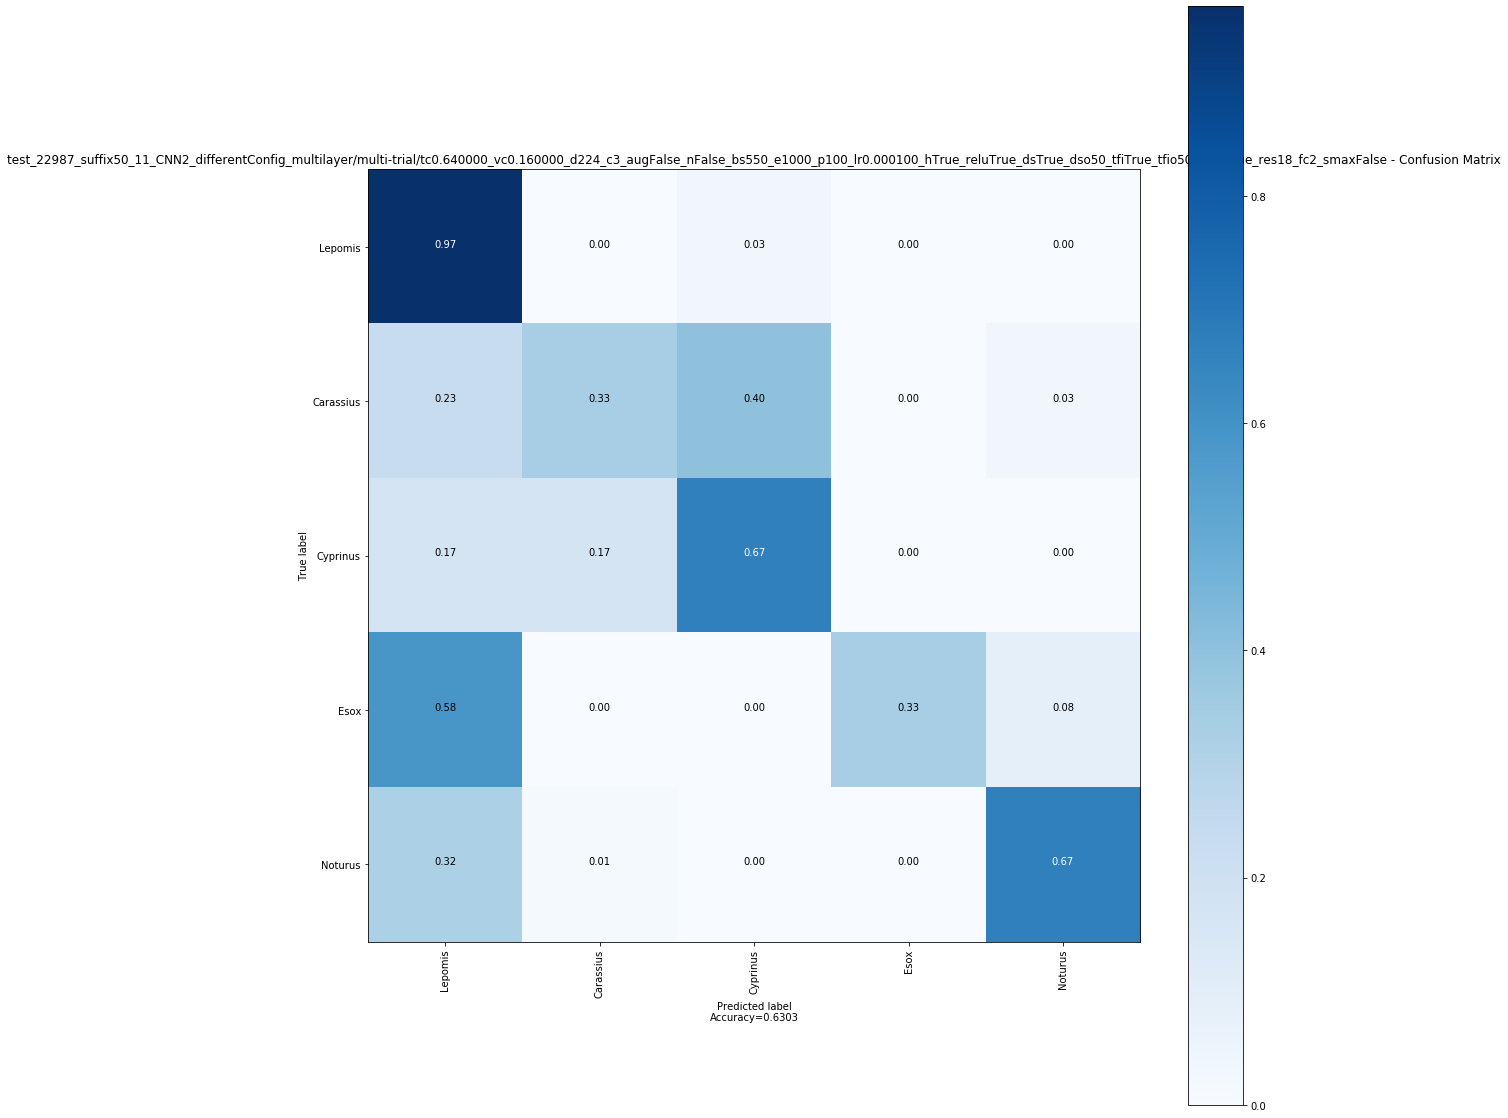

,genus,F1
0,0 Lepomis,0.544601
1,1 Carassius,0.425532
2,2 Cyprinus,0.625000
3,3 Esox,0.500000
4,4 Noturus,0.781250


experiment:  {'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'softmax': False, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 3, 'useAdam': True, 'resnet': '18', 'normalize': False}


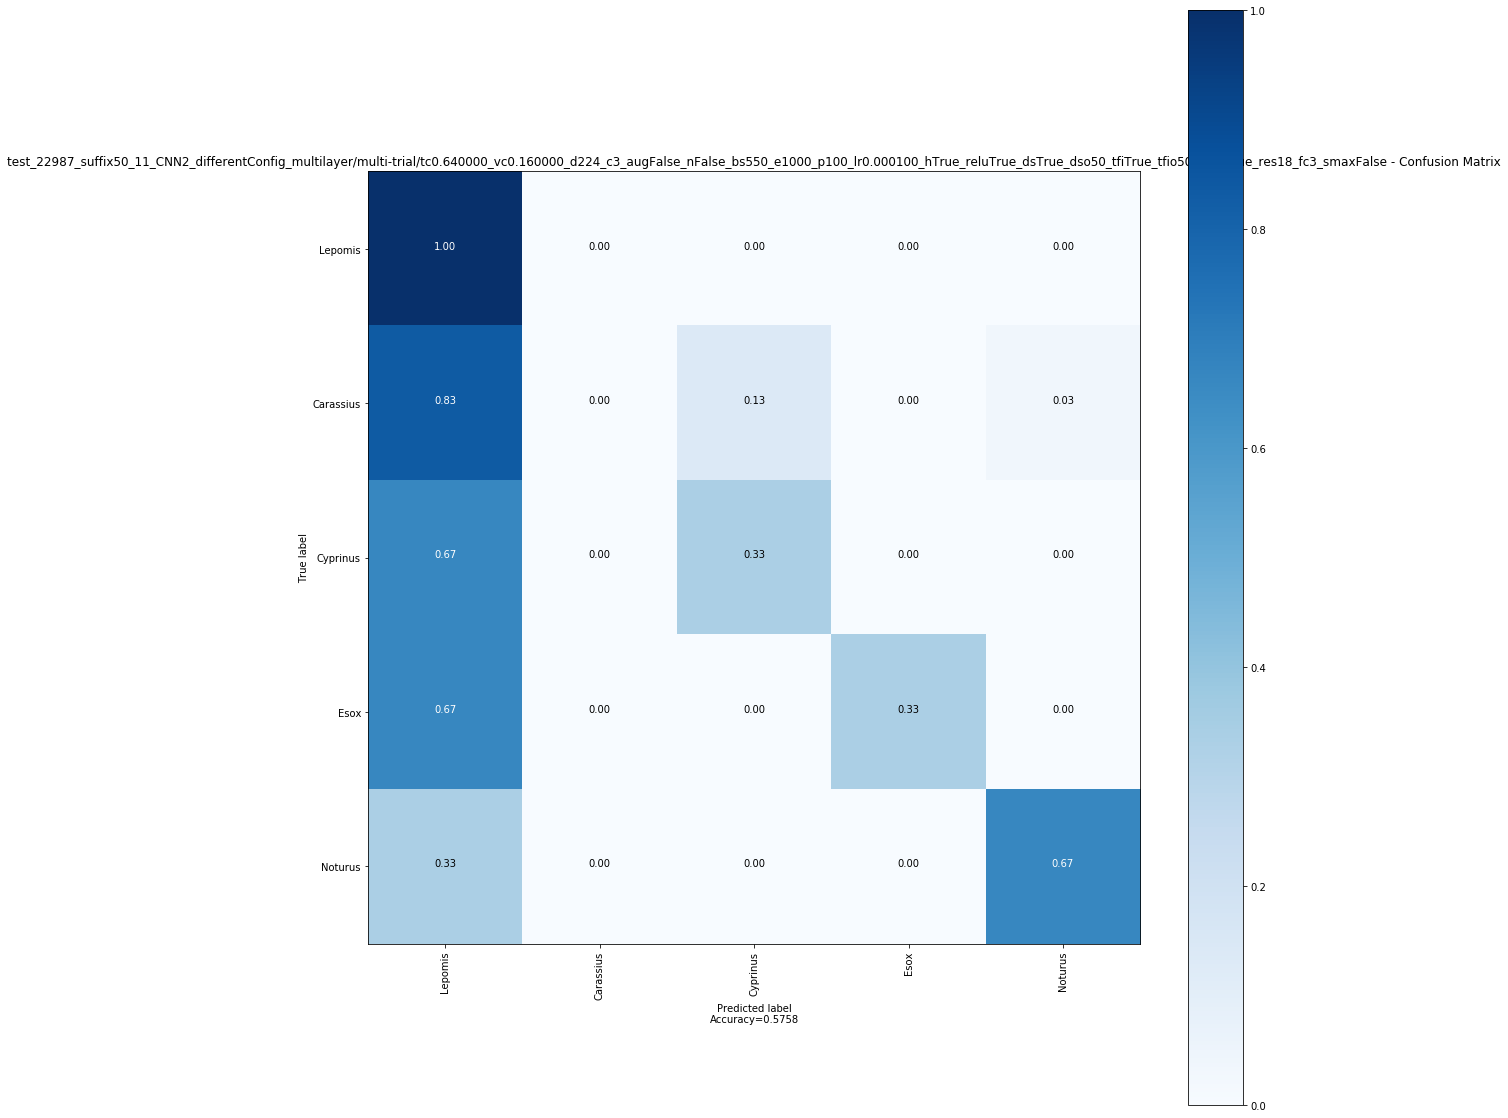

,genus,F1
0,0 Lepomis,0.470588
1,1 Carassius,0.000000
2,2 Cyprinus,0.454545
3,3 Esox,0.500000
4,4 Noturus,0.796813


In [8]:
paramsIterator = config_parser.getHyperpIter() 
for experiment_params in paramsIterator:
    experiment_params["numOfTrials"] = experiment_params["numOfTrials"] or 1
    if experiment_params["useHeirarchy"]:
        print("experiment: ", experiment_params)

        datasetManager.updateParams(experiment_params)
        dataset = datasetManager.getDataset()
    
        genusList = dataset.getGenusList()
        ts_genus.printTrialConfusionMatrix(experiment_params, genusList, True)
        ts_genus.printF1table(experiment_params, dataset)

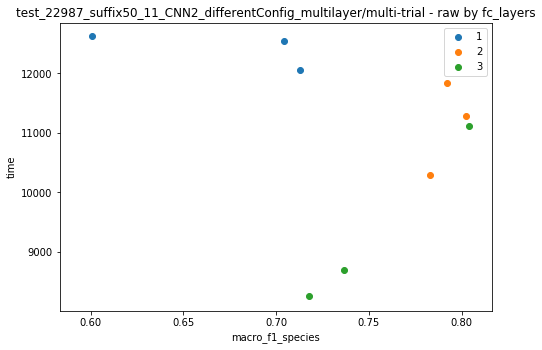

In [9]:
ts.trialScatter('macro_f1_species', 'time', False, 'fc_layers')

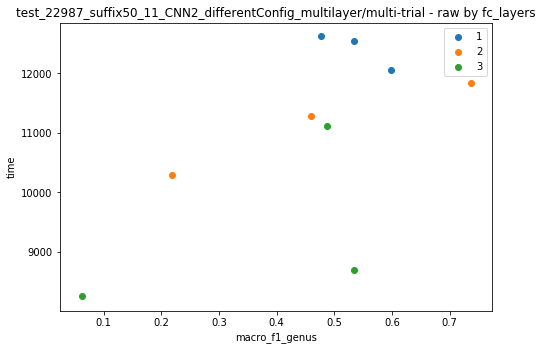

In [10]:
ts.trialScatter('macro_f1_genus', 'time', False, 'fc_layers')